# DE genes across diabetes trajectory clusters
Expression of T1D and T2D DE genes across T1D and T2D cluster progression trajectories.

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np

import pickle
from pathlib import Path

from sklearn.preprocessing import minmax_scale,maxabs_scale

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

from rpy2.robjects.packages import importr
grdevices = importr('grDevices')

In [2]:
%%R
library('ComplexHeatmap')
library(viridis)

In [3]:
ro.r('library("hypeR")')
ro.r("source(paste(Sys.getenv('WSCL'),'diabetes_analysis/data_exploration/','helper_hypeR.R',sep=''))")

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [4]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_de='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/'
path_de1=path_de+'de_diseased_T1_NODelim_meld/'
path_de2=path_de+'de_diseased_T2_VSGSTZ_meld_covarStudy/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'
path_save=path_de+'compare_T1D-NODelim_T2D-VSGSTZ/'

In [5]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [6]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

In [7]:
# Add full gene symbol info
var=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
           backed='r').var.copy()
var['gene_symbol']=h.get_symbols(var.index)
# Check that gene symbols not nan -
if (var.gene_symbol=='nan').sum() :
        raise ValueError('Some gene symbols are nan - requires different parsing')

In [11]:
# DE results and gene groups
de1=pd.read_table(path_de1+'deDataClusters.tsv')
de2=pd.read_table(path_de2+'deDataClusters.tsv')

## Cell groups

Cell cluster sizes

In [8]:
# How many cells per ssample are in each cl to be plotted?
studies=['STZ',"VSG",'NOD_elimination']
groups=['adult1','adult2','D-inter.','db/db+mSTZ','NOD-D']
pd.set_option('display.max_rows', 500)
display(adata_rn_b.obs.query('study in @studies and hc_gene_programs_parsed in @groups'
                    )[['study_sample_design','hc_gene_programs_parsed']].astype(str).\
                groupby('study_sample_design')['hc_gene_programs_parsed'].value_counts())
pd.reset_option('display.max_rows')

study_sample_design                hc_gene_programs_parsed
NOD_elimination_SRR7610295_8w      adult2                      139
                                   NOD-D                        27
                                   D-inter.                      8
                                   adult1                        1
NOD_elimination_SRR7610296_8w      adult2                       95
                                   NOD-D                        10
                                   db/db+mSTZ                    4
                                   D-inter.                      3
NOD_elimination_SRR7610297_8w      adult2                      175
                                   D-inter.                     19
                                   NOD-D                         9
                                   db/db+mSTZ                    4
NOD_elimination_SRR7610298_14w     NOD-D                       678
                                   adult2                       20
   

In [23]:
# How many cells per study are in each cl to be plotted?
studies=['STZ',"VSG",'NOD_elimination']
groups=['adult2','D-inter.','db/db+mSTZ','NOD-D']
adata_rn_b.obs.query('study in @studies and hc_gene_programs_parsed in @groups'
                    )[['study','hc_gene_programs_parsed']].astype(str).\
                groupby('study')['hc_gene_programs_parsed'].value_counts()

study            hc_gene_programs_parsed
NOD_elimination  NOD-D                       2562
                 adult2                       504
                 D-inter.                     130
                 db/db+mSTZ                    57
STZ              adult2                      4766
                 db/db+mSTZ                  2461
                 D-inter.                    1175
                 NOD-D                        125
VSG              db/db+mSTZ                 10968
                 adult2                      1007
                 D-inter.                     643
                 NOD-D                         70
Name: hc_gene_programs_parsed, dtype: int64

C: There are enough cells to keep adult2 and D-intermediate for all models and the diabetes-model specific clusters for others.

Make cell groups

In [9]:
# Make groups
# Subset data
studies=['STZ',"VSG",'NOD_elimination']
groups=['adult2','D-inter.','db/db+mSTZ','NOD-D']
adata_rn_b_sub=adata_rn_b[
    adata_rn_b.obs.query('study in @studies and hc_gene_programs_parsed in @groups').index,
    :].copy()
adata_rn_b_sub.obs['group']=adata_rn_b_sub.obs.apply(
    lambda x:x.hc_gene_programs_parsed+' ('+x.study_parsed+')',axis=1)
# Keep only relevant groups
groups=[g for g in adata_rn_b_sub.obs['group'].unique() 
        if 'adult2' in g or 'D-inter.' in g 
        or g=='NOD-D (8-16wNOD)' or g=='db/db+mSTZ (mSTZ)' or g=='db/db+mSTZ (db/db)']
adata_rn_b_sub=adata_rn_b_sub[
    adata_rn_b_sub.obs.query('group in @groups').index, :].copy()
print(adata_rn_b_sub.obs.group.unique())

['NOD-D (8-16wNOD)' 'adult2 (8-16wNOD)' 'D-inter. (8-16wNOD)'
 'D-inter. (db/db)' 'db/db+mSTZ (db/db)' 'adult2 (db/db)' 'adult2 (mSTZ)'
 'db/db+mSTZ (mSTZ)' 'D-inter. (mSTZ)']


In [10]:
# Order groups
adata_rn_b_sub.obs['group']=pd.Categorical(
    values=adata_rn_b_sub.obs['group'],ordered=True,
    categories=list(adata_rn_b_sub.obs[['hc_gene_programs_parsed','study_parsed','group']].drop_duplicates(
).sort_values(['hc_gene_programs_parsed','study_parsed']).group)
)
adata_rn_b_sub.obs.group.cat.categories

Index(['adult2 (8-16wNOD)', 'adult2 (mSTZ)', 'adult2 (db/db)',
       'D-inter. (8-16wNOD)', 'D-inter. (mSTZ)', 'D-inter. (db/db)',
       'NOD-D (8-16wNOD)', 'db/db+mSTZ (mSTZ)', 'db/db+mSTZ (db/db)'],
      dtype='object')

## Example genes plot
Plot just some example known genes to show how they change across the trajectory 

{'mainplot_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

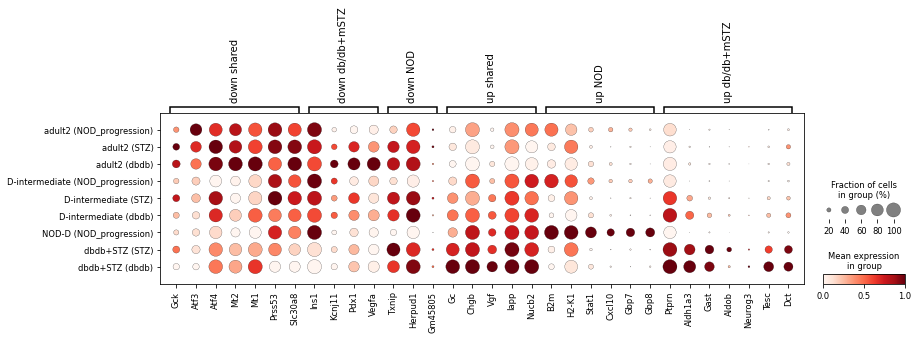

In [8]:
genes={
       'down shared':['Gck','Atf3','Atf4','Mt2','Mt1','Prss53','Slc30a8'],
    'down db/db+mSTZ':['Ins1','Kcnj11','Pdx1','Vegfa'],
    'down NOD':['Txnip','Herpud1','Gm45805'],
     'up shared':['Gc','Chgb','Vgf','Iapp','Nucb2'],
      'up NOD':['B2m','H2-K1','Stat1','Cxcl10','Gbp7','Gbp8'],
       'up db/db+mSTZ':[
           'Ptprn', 'Aldh1a3','Gast','Aldob','Neurog3','Tesc','Dct']
      }
sc.pl.dotplot(adata_rn_b_sub, var_names=genes,
              gene_symbols='gene_symbol',use_raw=False,
              groupby='group',
              standard_scale='var',
              show=False)

In [91]:
for group,gs in genes.items():
    print(group)
    print('T1D')
    display(de1.query('gene_symbol in @gs')[['qval','log2fc','gene_symbol']])
    print('T2D')
    display(de2.query('gene_symbol in @gs')[['qval','log2fc','gene_symbol']])

down shared
T1D


,qval,log2fc,gene_symbol
520,0.00000,-2.784022,Atf3
4487,0.00000,-0.426740,Prss53
5408,0.00000,-1.734229,Mt2
5409,0.00000,-2.034703,Mt1
6522,0.00145,-0.372204,Gck
8081,0.00000,-0.407999,Slc30a8
8228,0.00000,-0.444359,Atf4


T2D


,qval,log2fc,gene_symbol
614,0.0,-1.754434,Atf3
5109,0.0,-2.023482,Prss53
6138,0.0,-1.773015,Mt2
6139,0.0,-1.353436,Mt1
7416,0.0,-1.000416,Gck
9209,0.0,-2.373248,Slc30a8
9362,0.0,-0.779260,Atf4


down db/db+mSTZ
T1D


,qval,log2fc,gene_symbol
3386,2.045285e-02,0.209843,Pdx1
4193,7.556867e-01,0.055372,Kcnj11
9053,9.683065e-01,-0.004390,Vegfa
9781,3.428360e-07,0.168145,Ins1


T2D


,qval,log2fc,gene_symbol
3833,0.0,-1.103933,Pdx1
4764,0.0,-1.029909,Kcnj11
10281,0.0,-1.353880,Vegfa
11095,0.0,-1.322839,Ins1


down NOD
T1D


,qval,log2fc,gene_symbol
1932,0.000000e+00,-1.143799,Txnip
5411,0.000000e+00,-1.050974,Herpud1
5603,2.341255e-12,-2.688451,Gm45805


T2D


,qval,log2fc,gene_symbol
2190,0.272516,0.018591,Txnip
6141,0.000149,0.041048,Herpud1
6364,0.294353,-0.063987,Gm45805


up shared
T1D


,qval,log2fc,gene_symbol
1066,0.0,0.884665,Chgb
2995,0.0,1.793009,Gc
3292,0.0,2.171186,Vgf
3855,0.0,0.648272,Iapp
4396,0.0,0.487053,Nucb2


T2D


,qval,log2fc,gene_symbol
1226,0.0,2.020134,Chgb
3389,0.0,3.012924,Gc
3720,0.0,1.510097,Vgf
4363,0.0,1.212215,Iapp
5004,0.0,1.621848,Nucb2


up NOD
T1D


,qval,log2fc,gene_symbol
92,0.0,2.635864,Stat1
999,0.0,2.804964,B2m
2091,0.0,3.009623,Gbp7
3009,0.0,3.347675,Cxcl10
3048,0.0,3.829604,Gbp8
8953,0.0,2.207497,H2-K1


T2D


,qval,log2fc,gene_symbol
110,0.000000,-0.837194,Stat1
1148,0.000000,-0.998932,B2m
2369,0.000000,-1.581968,Gbp7
3401,0.000000,-1.941920,Cxcl10
10179,0.001386,-0.039068,H2-K1


up db/db+mSTZ
T1D


,qval,log2fc,gene_symbol
186,0.001226,-0.165865,Ptprn
5922,0.034609,-0.581285,Dct


T2D


,qval,log2fc,gene_symbol
220,0.0,0.831688,Ptprn
2575,0.0,3.535575,Aldob
3559,0.0,3.626120,Tesc
4809,0.0,3.894216,Aldh1a3
5403,0.0,2.452699,Neurog3
6723,0.0,2.179959,Dct
8011,0.0,6.422874,Gast


## Genes shared in T1D and T2D

### DE genes expression across clusters

In [29]:
# Order groups for heatmap
categories=list(adata_rn_b_sub.obs[['hc_gene_programs_parsed','study_parsed','group']
                                  ].drop_duplicates().sort_values(
                ['study_parsed','hc_gene_programs_parsed']).group)

Genes in down groups in both T1D and T2D.

In [160]:
# Expression data of shared DE genes
g=list(set(de1[de1.hc.fillna('nan').str.contains('down')].gene)&
       set(de2[de2.hc.fillna('nan').str.contains('down')].gene))
x=adata_rn_b_sub[:,g].to_df()
x['group']=adata_rn_b_sub.obs.group
x=x.groupby('group').mean()
# Filter 0 expr as some genes are 0 expr when using only these clusters
x=x.T[(x>0).any()].T
# Sclae per dataset
x['dataset']=pd.Series(x.index).apply(lambda x:x.split('(')[1].split(')')[0]).values
x=x.groupby('dataset').apply(
    lambda x: pd.DataFrame(minmax_scale(x.drop('dataset',axis=1)),
                           index=x.index,columns=x.drop('dataset',axis=1).columns))

In [162]:
# Add gene symbols to df names 
x.columns=var.loc[x.columns,'gene_symbol']

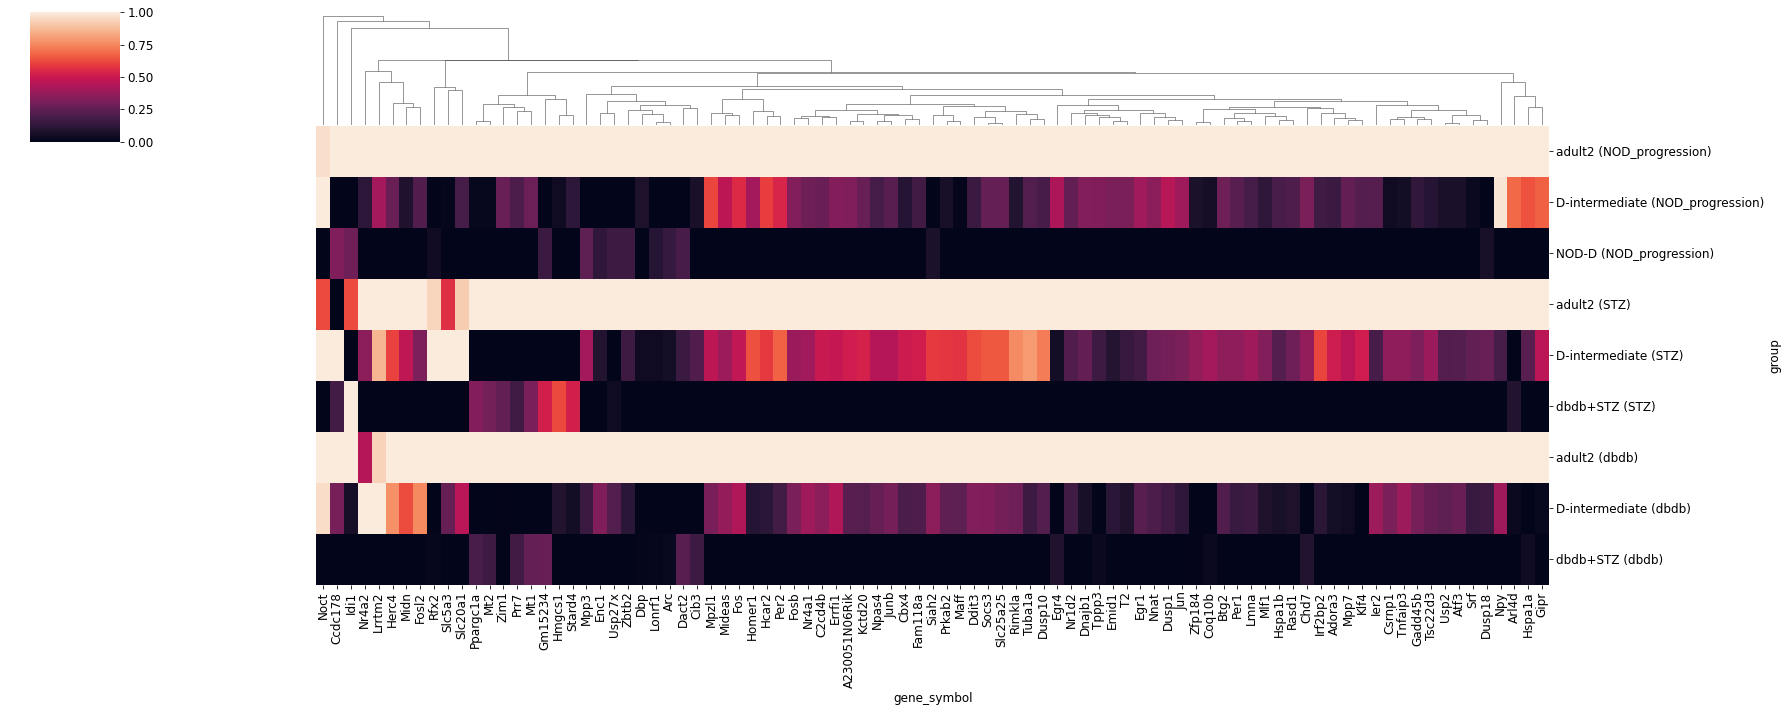

In [167]:
sb.clustermap(x.loc[categories,:],row_cluster=False,xticklabels=True,figsize=(25,10))
# Could maybe plot lFC on top

Genes in up groups in both T1D and T2D 

In [169]:
# Expression data of shared DE genes
# Get mean expr per group for DE genes
g=list(set(de1[de1.hc.fillna('nan').str.contains('up')].gene)&
       set(de2[de2.hc.fillna('nan').str.contains('up')].gene))
x=adata_rn_b_sub[:,g].to_df()
x['group']=adata_rn_b_sub.obs.group
x=x.groupby('group').mean()
# Filter 0 expr as some genes are 0 expr when using only these clusters
x=x.T[(x>0).any()].T
# Sclae per dataset
x['dataset']=pd.Series(x.index).apply(lambda x:x.split('(')[1].split(')')[0]).values
x=x.groupby('dataset').apply(
    lambda x: pd.DataFrame(minmax_scale(x.drop('dataset',axis=1)),
                           index=x.index,columns=x.drop('dataset',axis=1).columns))

In [171]:
# Add gene symbols to df names 
x.columns=var.loc[x.columns,'gene_symbol']

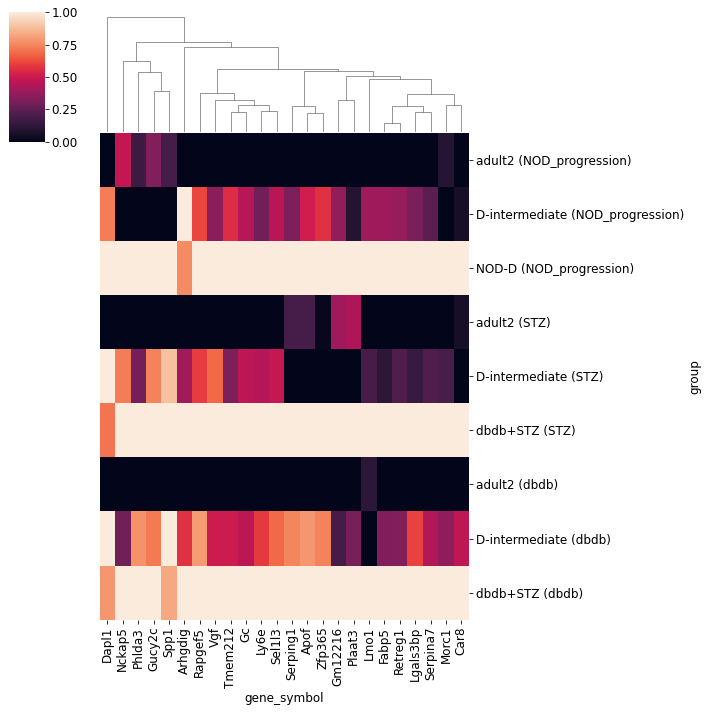

In [172]:
sb.clustermap(x.loc[categories,:],row_cluster=False,xticklabels=True,figsize=(10,10))
# Could maybe plot lFC on top

Shared up and down on the same plot

In [17]:
g_down=list(set(de1[de1.hc.fillna('nan').str.contains('down')].gene)&
       set(de2[de2.hc.fillna('nan').str.contains('down')].gene))
g_up=list(set(de1[de1.hc.fillna('nan').str.contains('up')].gene)&
       set(de2[de2.hc.fillna('nan').str.contains('up')].gene))

x=adata_rn_b_sub[:,g_down+g_up].to_df()
x['group']=adata_rn_b_sub.obs.group
x=x.groupby('group').mean()
# Filter 0 expr as some genes are 0 expr when using only these clusters
x=x.T[(x>0).any()].T
# Sclae per dataset
x['dataset']=pd.Series(x.index).apply(lambda x:x.split('(')[1].split(')')[0]).values
x=x.groupby('dataset').apply(
    lambda x: pd.DataFrame(minmax_scale(x.drop('dataset',axis=1)),
                           index=x.index,columns=x.drop('dataset',axis=1).columns))

# Cluster genes per down/up
# Direction (also serves for annotation)
directions= pd.concat([pd.Series(['down']*len(g_down),index=g_down),
           pd.Series(['up']*len(g_up),index=g_up)])
gene_list= h.opt_order_withincl(x.T,directions, cl_order=['down','up'])

In [18]:
# Name axes
x.columns.name='genes'
x.index.name='cell clusters (per dataset)'

In [22]:
# Make columns anno
direction_cmap={'down':'#8a9e59','up':'#c97fac'}
col_anno=directions.map(direction_cmap)
col_anno.name='direction'

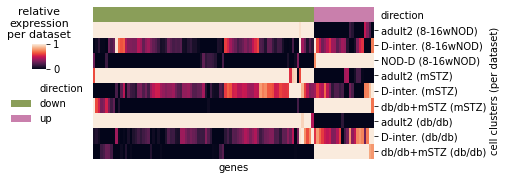

In [23]:
# Heatmap
w_dend=1
w_colors=0.3
nrow=x.shape[0]*0.24
ncol=x.shape[1]*0.05
w=ncol+w_dend
h=nrow+w_colors+w_dend
g=sb.clustermap(x.loc[categories,gene_list],
              row_cluster=False,col_cluster=False,xticklabels=False,
              col_colors=col_anno,
             cbar_pos=(0,0.46,0.03,0.1),
                figsize=(w,h),
                colors_ratio=(w_colors/w,0.8*w_colors/h),
                dendrogram_ratio=(w_dend/w,w_dend/h),
             )
# legends
# Cbar title
g.cax.set_title("relative\nexpression\nper dataset",fontsize=11)
# Add legend for col colors
legend_elements = [ Patch(alpha=0,label='direction')]+[
     Patch(facecolor=c,label=s) for s,c in direction_cmap.items()]
ax=g.fig.add_subplot(223)
ax.axis('off')
ax.legend(handles=legend_elements, bbox_to_anchor=(0.3,0.79),frameon=False)

#remove dendrogram
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

# Remove colors tick
g.ax_col_colors.yaxis.set_ticks_position('none') 

# Save fig
plt.savefig(path_fig+'heatmap_beta_diabetesSharedDE_clFineDInterDataset.png',
            dpi=300,bbox_inches='tight')

Same as above, but with marked gene names

In [24]:
# Add to R expression 
ro.globalenv['x_ordered']=x.loc[categories,gene_list]

In [34]:
# Gene name anno for R
down_mark=['Siah2', 'Herc4', 'Hspa1a', 'Cbx4', 'Ddit3', 'Dnajb1', 'Usp27x', 'Fos', 'Jun', 
      'Gadd45b', 'Btg2', 'Prkab2', 'Junb', 'Dusp10', 'Npy', 'Dusp1', 'Gipr', 'Dusp18', 
      'Irf2bp2', 'Usp2', 'Atf3', 'Tnfaip3', 'Nnat', 'Hspa1b', 'Socs3']
up_mark=['Plaat3', 'Gc', 'Fabp5', 'Dapl1', 'Phlda3', 'Spp1', 'Vgf']
genes_show=up_mark+down_mark
gene_list_symbols=var.loc[gene_list,'gene_symbol'].values.ravel()
genes_show_idx=[np.argwhere(gene_list_symbols==g)[0][0] for g in genes_show]
ro.globalenv['genes_show']=genes_show
ro.globalenv['genes_show_idx']=genes_show_idx

In [52]:
# Add DE directions in R
ro.globalenv['directions_anno']=pd.DataFrame(directions).T[gene_list]

In [70]:
%%R
# Gene annotation - names and direction
# Prepare gene name data type
genes_show<-unlist(genes_show)
genes_show_idx<-unlist(genes_show_idx)
# Prepare direction data type
directions_anno<-factor(directions_anno,levels = c('down','up'))
ha_col = columnAnnotation(
    genes=anno_mark(at = genes_show_idx, labels = genes_show),
    direction=directions_anno,
    col = list(direction = setNames( c("#8a9e59", "#c97fac"),c('down','up'))),
    annotation_name_side = "left"
)


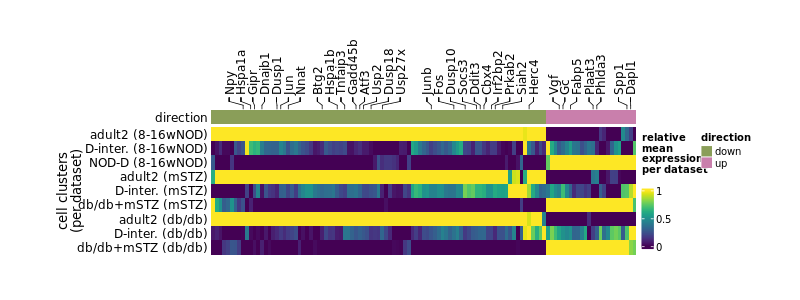

In [75]:
%%R -w 800 -h 300 
h<-Heatmap(x_ordered,col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = FALSE, show_row_names = TRUE,
       row_title ="cell clusters\n(per dataset)",
       top_annotation=ha_col,
       row_names_side = "left",
       heatmap_legend_param = list( title = "relative\nmean\nexpression\nper dataset\n"),
       row_gap = unit(0, "mm"),
       width= unit(15, "cm"), height= unit(4.5, "cm"),
       show_row_dend = FALSE, 
       )
draw(h)

In [77]:
%%R -i path_fig
pdf(file=paste0(path_fig,"heatmap_beta_diabetesSharedDE_clFineDInterDataset_annotated.pdf"), 
    width=9.7, height=3)
h<-Heatmap(x_ordered,col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = FALSE, show_row_names = TRUE,
       row_title ="cell clusters\n(per dataset)",
       top_annotation=ha_col,
       row_names_side = "left",
       heatmap_legend_param = list( title = "relative\nmean\nexpression\nper dataset\n"),
       row_gap = unit(0, "mm"),
       width= unit(15, "cm"), height= unit(4.5, "cm"),
       show_row_dend = FALSE, 
       )
draw(h)

### Enrichment of shared up/down group genes

In [149]:
# Ref genes - present in both T1D and T2D summaries
ref=set.intersection(*[set(d.gene) for d in [de1,de2]])
ref=var.loc[ref,'gene_symbol'].to_list()
ro.globalenv['ref']=ref

In [151]:
# Get gene sets: GO+KEGG+Reactome
print('MSIGdb version:',ro.r(f'msigdb_version()'))
gene_sets_go=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C5',subcategories=c('GO:BP','GO:CC','GO:MF'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
gene_sets_kegg=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('KEGG'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
gene_sets_reactome=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('REACTOME'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
%R -i gene_sets_go -i gene_sets_kegg -i gene_sets_reactome -o gene_sets gene_sets=c(gene_sets_go,gene_sets_kegg,gene_sets_reactome)
print('N gene sets:',len(gene_sets))
ro.globalenv['gene_sets']=gene_sets

MSIGdb version: ['v7.4.1']
N gene sets: 8716


Direction up
N genes 24
N enriched gene sets: 0
Direction down
N genes 89
N enriched gene sets: 249
Top enriched gene sets


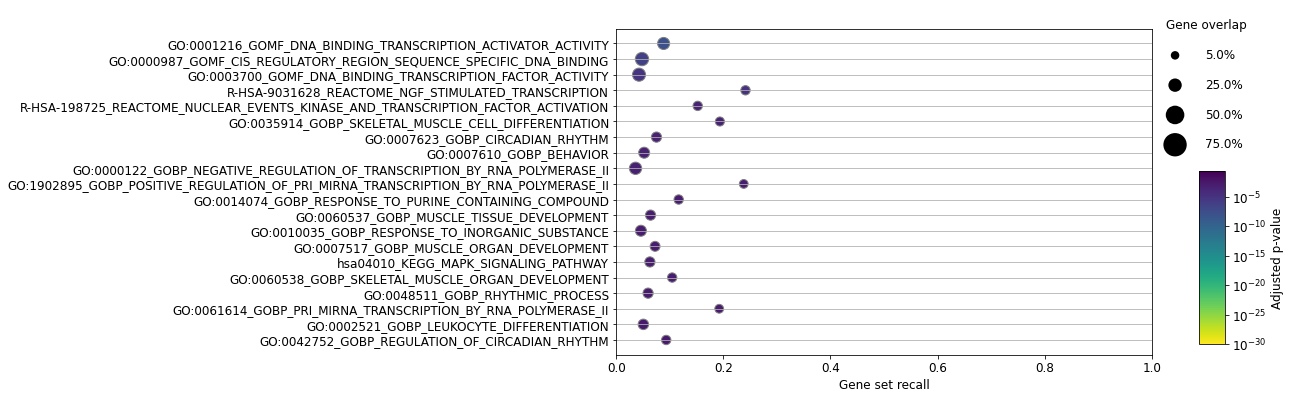

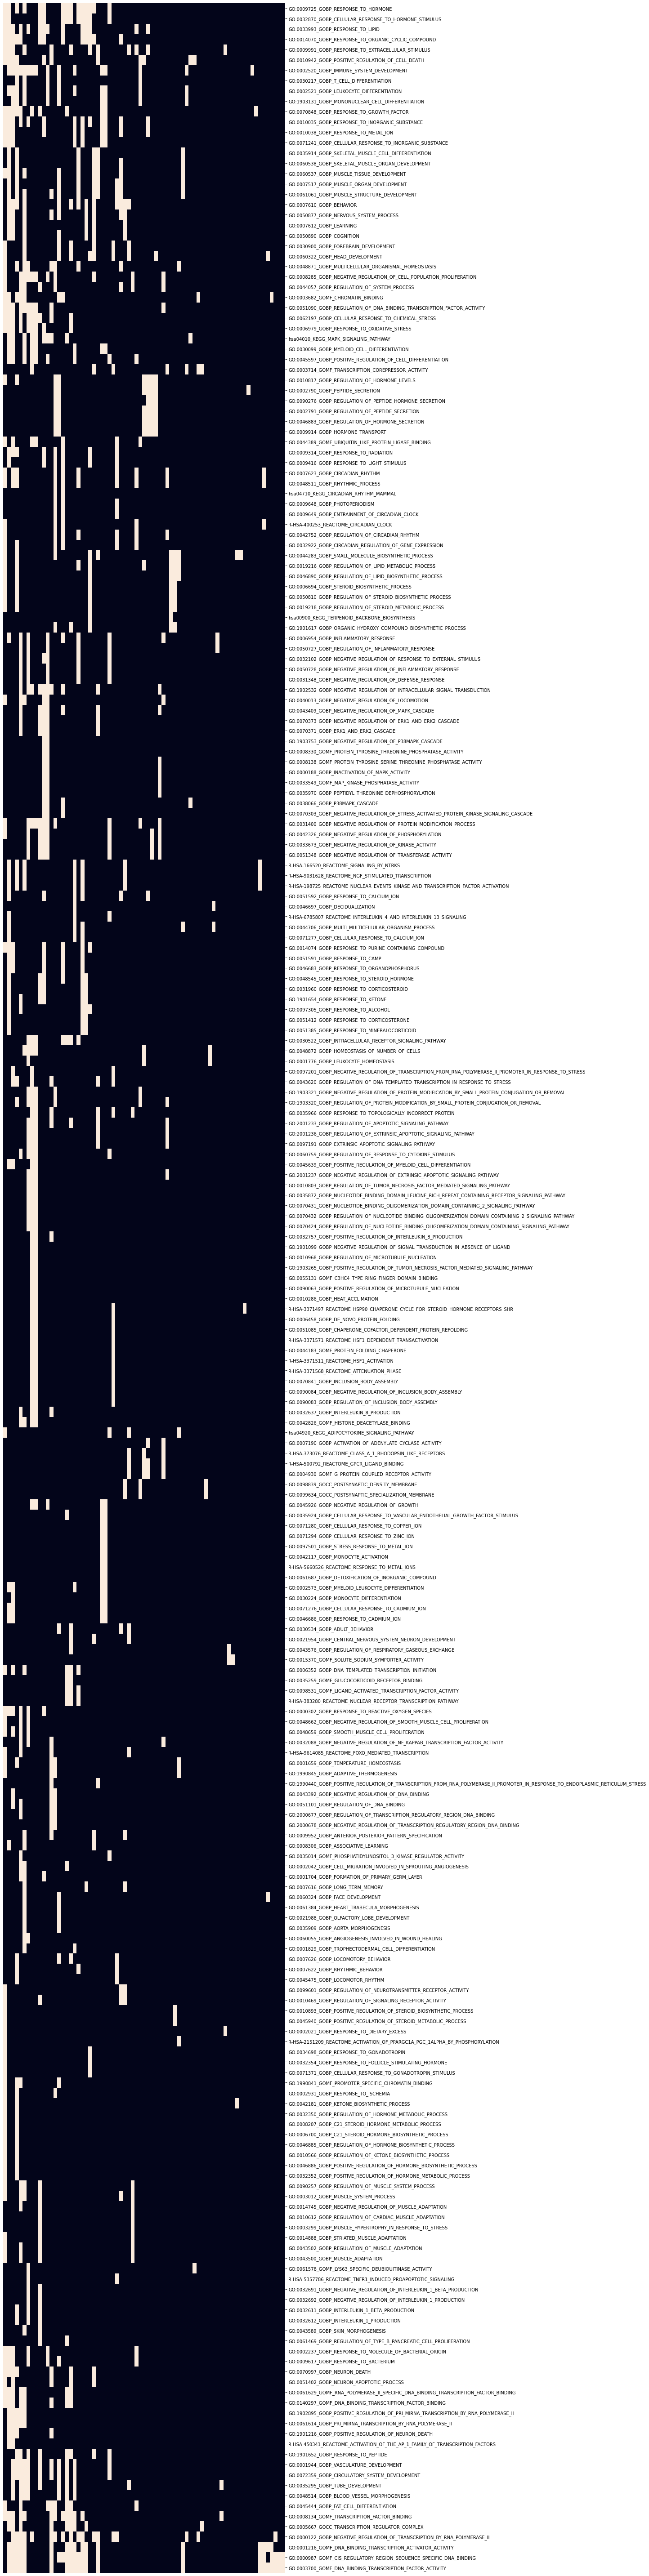

In [191]:
# Perform enrichment per cl
enrich_datas={}
for direction in ['up','down']:
    print('Direction',direction)    
    # Query genes
    genes=list(set(de1[de1.hc.fillna('nan').str.contains(direction)].gene)&
               set(de2[de2.hc.fillna('nan').str.contains(direction)].gene))

    genes=var.loc[genes,'gene_symbol'].to_list()
    print('N genes %i'%len(genes))

    # Calculate enrichment
    enrich_fdr=0.25
    ro.globalenv['gs_fdr']=enrich_fdr
    ro.globalenv['genes']=genes
    res=ro.r(f'hypeR(signature=as.vector(unlist(genes)),genesets=gene_sets,test = "hypergeometric",background =  as.vector(unlist(ref)),pval = 1,fdr = gs_fdr,plotting = FALSE,quiet = TRUE)')
    ro.globalenv['res']=res
    data=ro.r(f'res$data')
    enrich_datas[direction]=data
    print('N enriched gene sets:',data.shape[0])

    if data.shape[0]>0:
        # Plot top enriched gene sets
        print('Top enriched gene sets')
        data['recall']=data['overlap']/data['geneset']
        data['query_size']=len(genes)
        h.plot_enrich(data=data.rename(
            {'label':'name','fdr':'p_value','overlap':'intersection_size'},axis=1),
            n_terms=20, save=False,min_pval=10**-30, max_pval=enrich_fdr,percent_size=True,
               recall_lim=(0,1))
        h.plot_enr_heatmap(data=data,n_gs=None,xticklabels=False,yticklabels=True)

# Save enrichment tables
writer = pd.ExcelWriter(path_save+'sharedClUpDown_enrichment.xlsx',
                        engine='xlsxwriter') 
for sheet,data in enrich_datas.items():
    data.to_excel(writer, sheet_name=str(sheet))   
writer.save()